### GENERATING NAMES WITH A CHARACTER-LEVEL RNN

#### 1. Preparing the Data

In [1]:
from __future__ import unicode_literals, print_function, division
from io import open
import glob
import os
import unicodedata
import string

all_letters = string.ascii_letters + " .,;'-"
n_letters = len(all_letters) + 1

def findFiles(path): return glob.glob(path)

def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]

category_lines = {}
all_categories = []
for filename in findFiles('data/names/*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines
    
n_categories = len(all_categories)

print('# categories:', n_categories, all_categories)
print(unicodeToAscii("O'Néàl"))

# categories: 18 ['Czech', 'German', 'Arabic', 'Japanese', 'Chinese', 'Vietnamese', 'Russian', 'French', 'Irish', 'English', 'Spanish', 'Greek', 'Italian', 'Portuguese', 'Scottish', 'Dutch', 'Korean', 'Polish']
O'Neal


In [2]:
import torch
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        
        self.i2h = nn.Linear(n_categories + input_size + hidden_size,  hidden_size)
        self.i2o = nn.Linear(n_categories + input_size + hidden_size, output_size)
        self.o2o = nn.Linear(hidden_size + output_size, output_size)
        self.dropout = nn.Dropout(0.1)
        self.softmax = nn.LogSoftmax(dim=1)
        
    def forward(self, category, input, hidden):
        input_combined = torch.cat((category, input, hidden), 1)
        hidden = self.i2h(input_combined)
        output = self.i2o(input_combined)
        output_combined = torch.cat((hidden, output), 1)
        output = self.o2o(output_combined)
        output = self.dropout(output)
        output = self.softmax(output)
        return output, hidden
    
    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

#### 3. Preparing for training

In [3]:
import random

def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

def randomTrainingPair():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    return category, line

In [4]:
# One-hot vector for category
def categoryTensor(category):
    li = all_categories.index(category)
    tensor = torch.zeros(1, n_categories)
    tensor[0][li] = 1
    return tensor

# One-hot matrix of first to last letters (not including EOS) for input
def inputTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li in range(len(line)):
        letter = line[li]
        tensor[li][0][all_letters.find(letter)] = 1
    return tensor

# LongTensor of second letter to end (EOS) for target
def targetTensor(line):
    letter_indexes = [all_letters.find(line[li]) for li in range(1, len(line))]
    letter_indexes.append(n_letters - 1)
    return torch.LongTensor(letter_indexes)

In [5]:
def randomTrainingExample():
    category, line = randomTrainingPair()
    category_tensor = categoryTensor(category)
    input_line_tensor = inputTensor(line)
    target_line_tensor = targetTensor(line)
    return category_tensor, input_line_tensor, target_line_tensor

#### 4. Training the Network

In [6]:
criterion = nn.NLLLoss()

learning_rate = 0.0005

def train(category_tensor, input_line_tensor, target_line_tensor):
    target_line_tensor = target_line_tensor.unsqueeze(-1)
    hidden = rnn.initHidden()
    
    rnn.zero_grad()
    
    loss = 0
    
    for i in range(input_line_tensor.size(0)):
        output, hidden = rnn(category_tensor, input_line_tensor[i], hidden)
        l = criterion(output, target_line_tensor[i])
        loss += l
    
    loss.backward()
    for p in rnn.parameters():
        p.data.add_(-learning_rate, p.grad.data)
    
    return output, loss.item() / input_line_tensor.size(0)

In [7]:
import time
import math

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

In [8]:
rnn = RNN(n_letters, 128, n_letters)

n_iters = 100000
print_every = 5000
plot_every = 500
all_losses = []
total_loss = 0

start = time.time()

for iter in range(1, n_iters + 1):
    output, loss = train(*randomTrainingExample())
    total_loss += loss
    if iter % print_every == 0:
        print('%s (%d %d%%) %.4f' % (timeSince(start), iter, iter / n_iters * 100, loss))
        
    if iter % plot_every == 0:
        all_losses.append(total_loss / plot_every)
        total_loss = 0

0m 10s (5000 5%) 2.6240
0m 20s (10000 10%) 3.0744
0m 30s (15000 15%) 2.8151
0m 40s (20000 20%) 2.5417
0m 50s (25000 25%) 2.4702
1m 0s (30000 30%) 2.5891
1m 10s (35000 35%) 2.7116
1m 20s (40000 40%) 2.8642
1m 30s (45000 45%) 3.6692
1m 40s (50000 50%) 2.1120
1m 50s (55000 55%) 2.5450
2m 0s (60000 60%) 2.5398
2m 10s (65000 65%) 1.5394
2m 20s (70000 70%) 2.6512
2m 31s (75000 75%) 3.3575
2m 42s (80000 80%) 2.2705
2m 52s (85000 85%) 2.5556
3m 3s (90000 90%) 0.8479
3m 14s (95000 95%) 3.1637
3m 24s (100000 100%) 2.0783


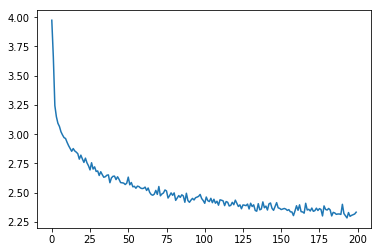

In [10]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)

#### 4. Sampling the Network

In [20]:
max_length = 20

# Sample from a category and starting letter
def sample(category, start_letter='A'):
    with torch.no_grad():
        category_tensor = categoryTensor(category)
        input = inputTensor(start_letter)
        hidden = rnn.initHidden()
        
        output_name = start_letter
        
        for i in range(max_length):
            output, hidden = rnn(category_tensor, input[0], hidden)
            topv, topi = output.topk(1)
            topi = topi[0][0]
            if topi == n_letters - 1:
                break
            else:
                letter = all_letters[topi]
                output_name += letter
            input = inputTensor(letter)
        return output_name

def samples(category, start_letters='ABC'):
    for start_letter in start_letters:
        print(sample(category, start_letter))
        
samples('Chinese', 'CHI')

Cha
Han
Iun
